In [18]:
from pathlib import Path
import os
import pandas as pd

notebook_dir = Path(r"c:\Users\kaidc\Documents\Github\quadruped_design\testing\data\CurrentTests").resolve()
os.chdir(notebook_dir)

# Functions

In [19]:
current_topic_labels = {
    "/joint_states.effort[0]": "Hip Roll Current",
    "/joint_states.effort[1]": "Hip Pitch Current",
    "/joint_states.effort[2]": "Knee Pitch Current",
}

def plot_data(df, title, time_col="elapsed time", topic_labels=None, x_label=None, y_label="value", start=None, end=None, legend_loc=None, error_pair=None, error_label="error", line_colors=None, error_color=None):
    import matplotlib.pyplot as plt

    if time_col not in df.columns:
        raise ValueError(f"Missing time column: {time_col}")

    # Plot all non-time columns as topics
    topic_cols = [c for c in df.columns if c not in {"timestamp", "elapsed time"}]
    if not topic_cols:
        raise ValueError("No topic columns to plot.")

    if topic_labels is None:
        topic_labels = {}

    plot_df = df.copy()
    if start is not None:
        plot_df = plot_df[plot_df[time_col] >= start]
    if end is not None:
        plot_df = plot_df[plot_df[time_col] <= end]

    if plot_df.empty:
        raise ValueError("No data in the requested time range.")

    error_series = None
    if error_pair is not None:
        actual_col, target_col = error_pair
        if actual_col not in plot_df.columns or target_col not in plot_df.columns:
            raise ValueError(f"Missing error columns: {actual_col}, {target_col}")
        error_series = plot_df[actual_col] - plot_df[target_col]

    # Shift elapsed time to start at zero when trimming
    if time_col == "elapsed time" and (start is not None or end is not None):
        plot_df = plot_df.copy()
        plot_df[time_col] = plot_df[time_col] - plot_df[time_col].iloc[0]

    plt.figure(figsize=(10, 6))
    for topic in topic_cols:
        label = topic_labels.get(topic, topic)
        color = None
        if line_colors is not None:
            color = line_colors.get(topic)
        plt.plot(plot_df[time_col], plot_df[topic], label=label, color=color)
    if error_series is not None:
        plt.plot(plot_df[time_col], error_series, label=error_label, color=error_color)
    plt.title(title)
    plt.xlabel(x_label if x_label is not None else time_col)
    plt.ylabel(y_label if y_label is not None else "value")
    if legend_loc is None:
        plt.legend()
    else:
        plt.legend(loc=legend_loc)
    plt.grid()
    plt.show()

In [31]:
import re
import difflib
import pandas as pd

_digits_re = re.compile(r'\d+')

def _normalize_feature_name(name):
    return re.sub(r"[^a-z0-9]+", "", str(name).lower())

def _digit_signature(name):
    return tuple(int(d) for d in _digits_re.findall(str(name)))

def concat_by_similar_feature_names(dfs, axis=0, similarity_threshold=0.85, ignore_cols=("timestamp", "elapsed time"), normalizer=None, ignore_index=None, block_digit_mismatch=True):
    """
    Concatenate dataframes after renaming columns so similar feature names match.

    Returns (combined_df, column_maps) where column_maps is a list of dicts
    mapping original column names to the canonical column names used.
    """
    if normalizer is None:
        normalizer = _normalize_feature_name

    canonical = []  # list of (canon_name, canon_norm, canon_digits)
    column_maps = []

    for df in dfs:
        col_map = {}
        for col in df.columns:
            if ignore_cols and col in ignore_cols:
                col_map[col] = col
                continue
            norm = normalizer(col)
            digits = _digit_signature(col)
            best_name = None
            best_score = 0.0
            for canon_name, canon_norm, canon_digits in canonical:
                if block_digit_mismatch and digits and canon_digits and digits != canon_digits:
                    continue
                if canon_norm == norm:
                    best_name = canon_name
                    best_score = 1.0
                    break
                score = difflib.SequenceMatcher(None, norm, canon_norm).ratio()
                if score > best_score:
                    best_score = score
                    best_name = canon_name
            if best_name is not None and best_score >= similarity_threshold:
                col_map[col] = best_name
            else:
                canonical.append((col, norm, digits))
                col_map[col] = col
        column_maps.append(col_map)

    renamed = [df.rename(columns=column_maps[i]) for i, df in enumerate(dfs)]
    if ignore_index is None:
        ignore_index = (axis == 0)
    combined = pd.concat(renamed, axis=axis, ignore_index=ignore_index)
    return combined, column_maps

# Example:
# combined, maps = concat_by_similar_feature_names([df1, df2, df3])


In [48]:
def crop_by_time(df, start=None, end=None, time_col='elapsed time'):
    """Return a copy of df cropped between start and end (inclusive)."""
    if time_col not in df.columns:
        raise ValueError(f'Missing time column: {time_col}')
    cropped = df
    if start is not None:
        cropped = cropped[cropped[time_col] >= start]
    if end is not None:
        cropped = cropped[cropped[time_col] <= end]
    return cropped.copy()

# Example:
# cropped_no_load = crop_by_time(combined_no_load_c, start=2.0, end=8.0)


# No-Load Current Data

In [21]:
fk1 = pd.read_csv("No_load/aligned_fk1.csv")
fk2 = pd.read_csv("No_load/aligned_fk2.csv")
fk3 = pd.read_csv("No_load/aligned_fk3.csv")
ik_crouched = pd.read_csv("No_load/aligned_crouched.csv")
ik_extended = pd.read_csv("No_load/aligned_extended.csv")
ik_standard = pd.read_csv("No_load/aligned_standard.csv")


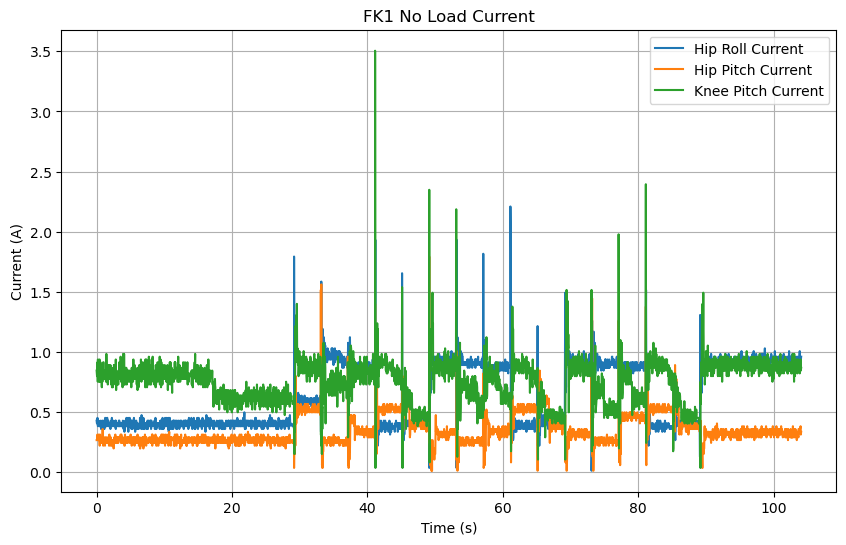

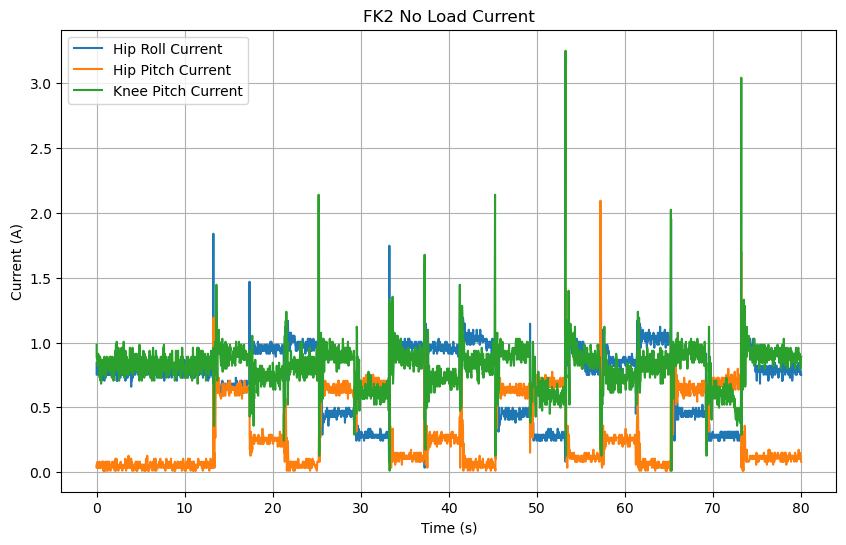

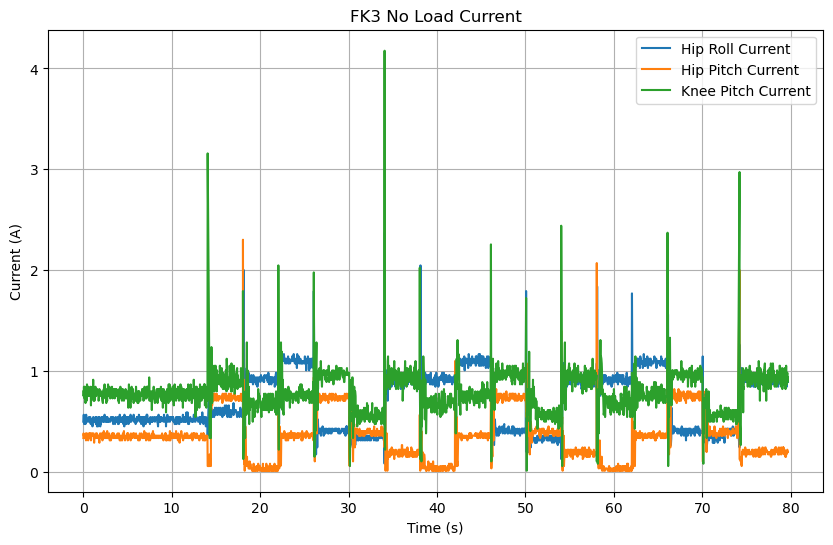

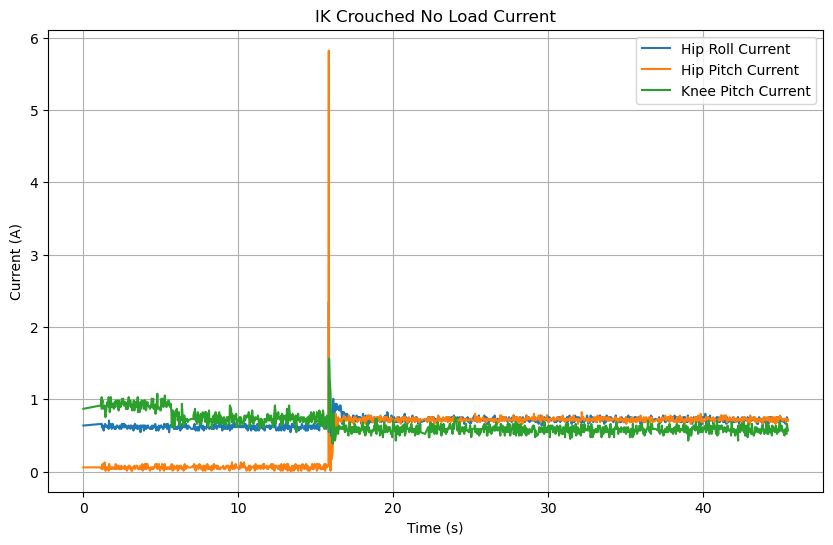

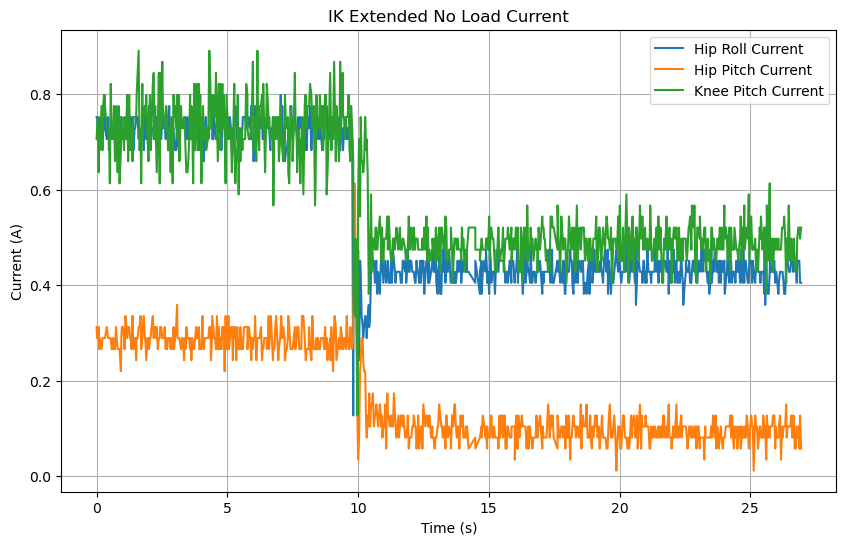

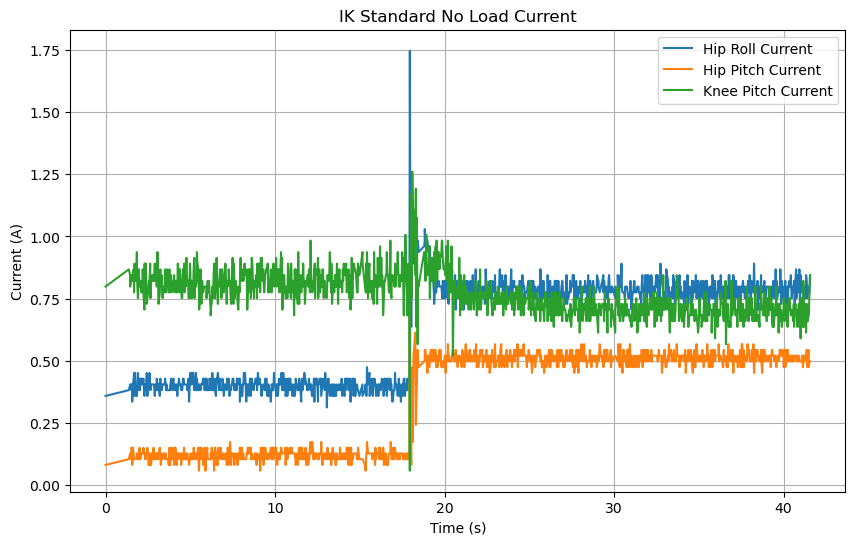

In [ ]:
plot_data(fk1, title="FK1 No Load Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(fk2, title="FK2 No Load Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(fk3, title="FK3 No Load Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(ik_crouched, title="IK Crouched No Load Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(ik_extended, title="IK Extended No Load Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(ik_standard, title="IK Standard No Load Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)

In [71]:
fk1_cropped = crop_by_time(fk1, start=28, end=100)
fk2_cropped = crop_by_time(fk2, start=12)
fk3_cropped = crop_by_time(fk3, start=12)
ik_crouched_cropped = crop_by_time(ik_crouched, start=15, end=18)
ik_extended_cropped = crop_by_time(ik_extended, start=8, end=15)
ik_standard_cropped = crop_by_time(ik_standard, start=16, end=23)

# plot_data(
#     ik_standard_cropped,
#     title="No Load Current (Cropped)",
#     y_label="Current (A)",
#     x_label="Time (s)",
#     topic_labels=current_topic_labels,
# )

# Dynamic Current Data

In [23]:
imped1 = pd.read_csv("Dynamic/aligned_imped1.csv")
imped2 = pd.read_csv("Dynamic/aligned_imped2.csv")
imped3 = pd.read_csv("Dynamic/aligned_imped3.csv")
impact3 = pd.read_csv("Dynamic/aligned_impact3.csv")
impact6 = pd.read_csv("Dynamic/aligned_impact6.csv")
impact9 = pd.read_csv("Dynamic/aligned_impact9.csv")
impact12 = pd.read_csv("Dynamic/aligned_impact12.csv")
impact12again = pd.read_csv("Dynamic/aligned_impact12again.csv")


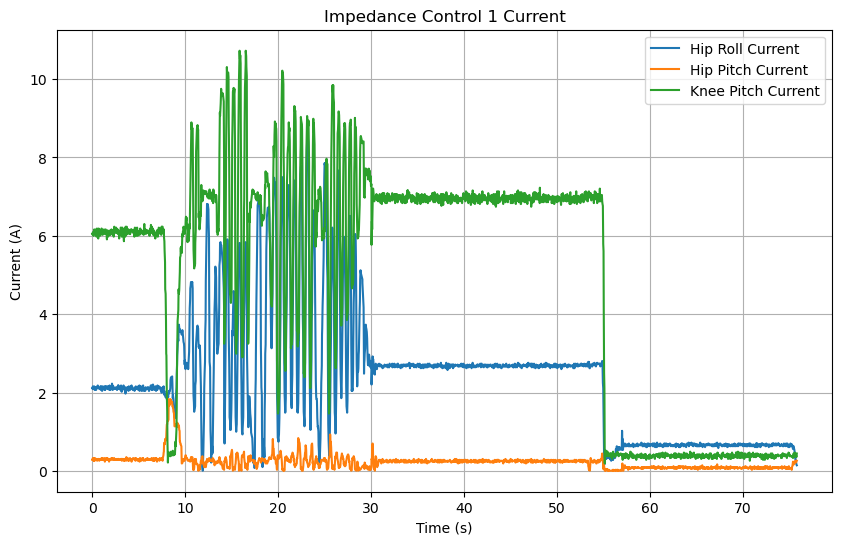

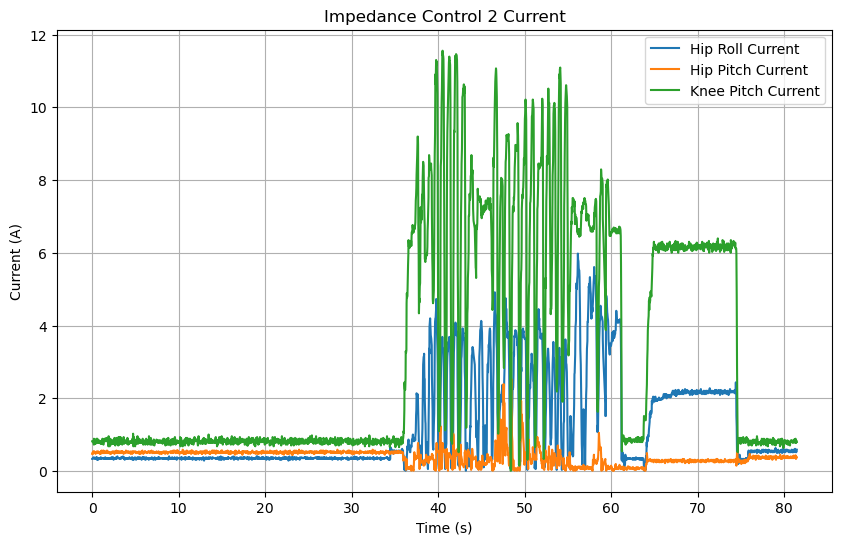

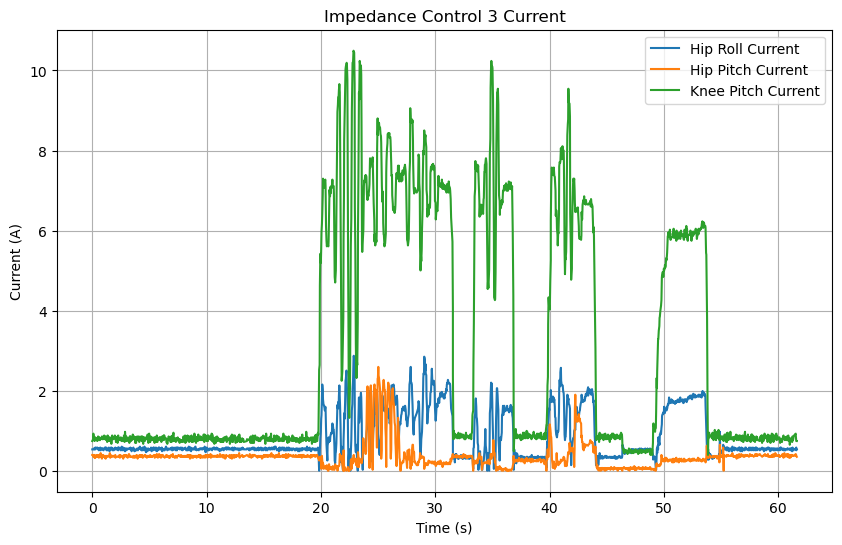

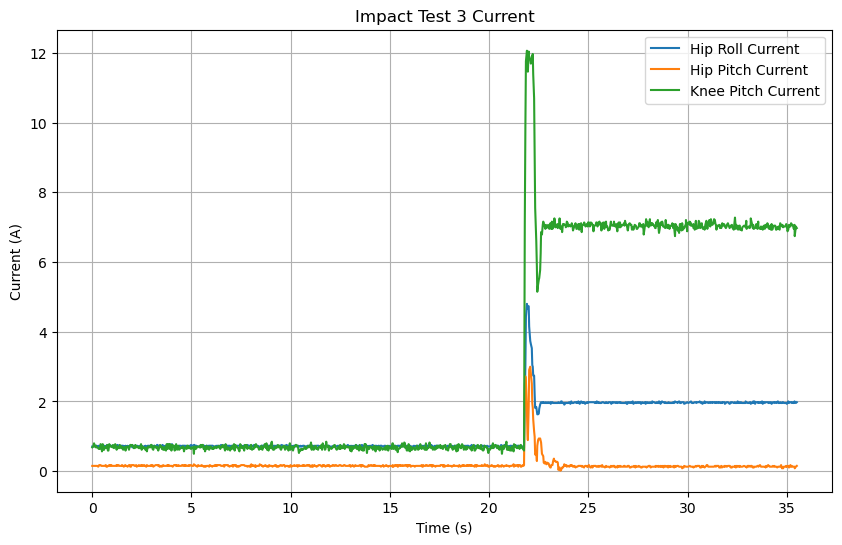

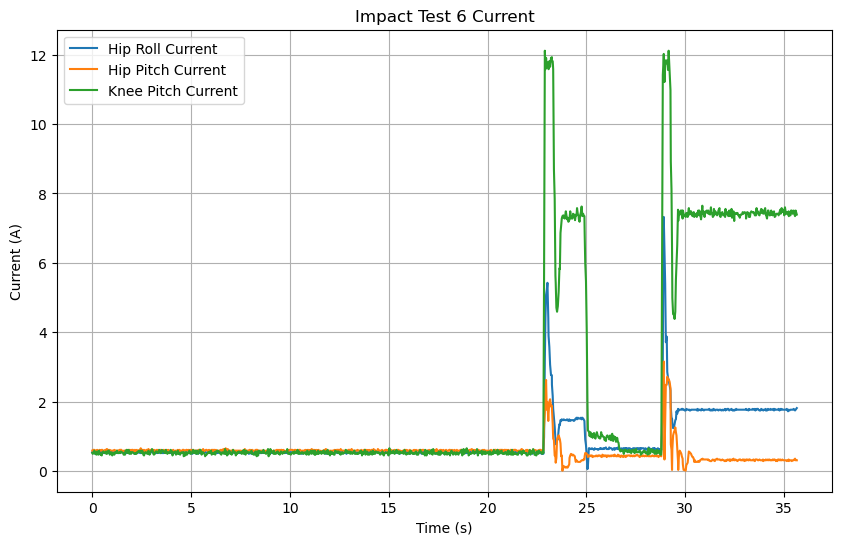

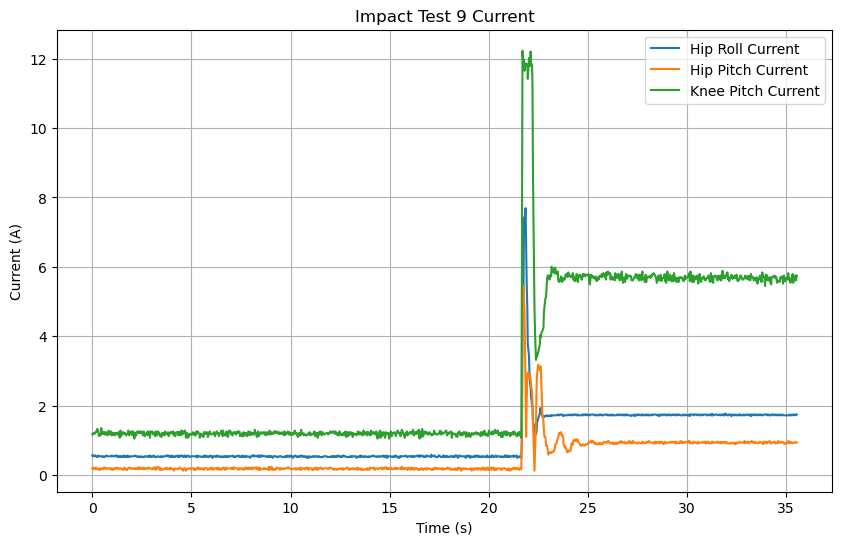

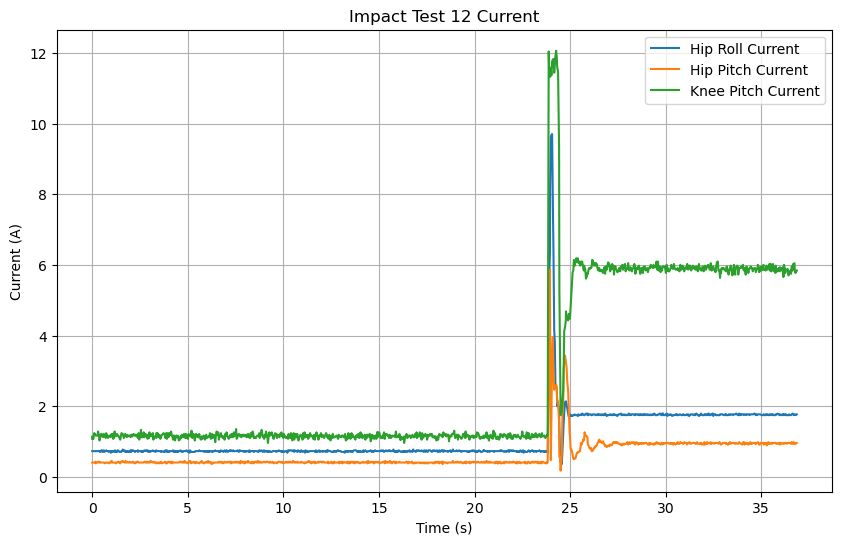

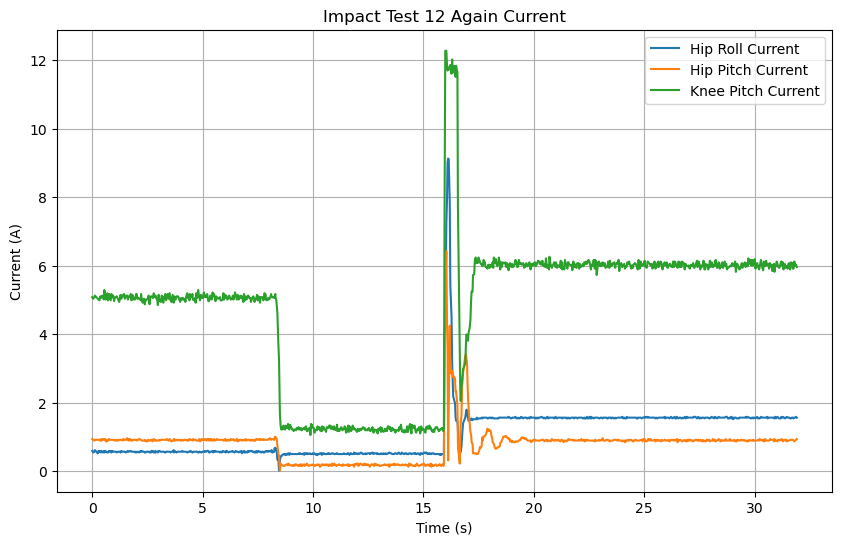

In [24]:
plot_data(imped1, title="Impedance Control 1 Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(imped2, title="Impedance Control 2 Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(imped3, title="Impedance Control 3 Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(impact3, title="Impact Test 3 Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(impact6, title="Impact Test 6 Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(impact9, title="Impact Test 9 Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(impact12, title="Impact Test 12 Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)
plot_data(impact12again, title="Impact Test 12 Again Current", y_label="Current (A)", x_label="Time (s)", topic_labels=current_topic_labels)


In [134]:
imped1_cropped = crop_by_time(imped1, start=9, end=31)
imped2_cropped = crop_by_time(imped2, start=36, end=61)
imped3_cropped = crop_by_time(imped3, start=19, end=45)
impact3_cropped = crop_by_time(impact3, start=21.5, end=24)
impact6_cropped = crop_by_time(impact6, start=22.5, end=32)
impact9_cropped = crop_by_time(impact9, start=21.5, end=25)
impact12_cropped = crop_by_time(impact12, start=23.5, end=28)
impact12again_cropped = crop_by_time(impact12again, start=15.5, end=20)

# plot_data(
#     impact12again_cropped,
#     title="Dynamic Current (Cropped)",
#     y_label="Current (A)",
#     x_label="Time (s)",
#     topic_labels=current_topic_labels,
# )

# Concat Data On Joint Basis

In [37]:
# Combine all specified dfs and export effort-only view
no_load_dfs = [
    fk1, fk2, fk3,
    ik_crouched, ik_extended, ik_standard,
]

combined, maps = concat_by_similar_feature_names(no_load_dfs)
effort_cols = [c for c in combined.columns if str(c).startswith('/joint_states.effort[')]
effort_cols = list(dict.fromkeys(effort_cols))

cols = ['elapsed time'] + effort_cols if 'elapsed time' in combined.columns else effort_cols
combined_effort = combined[cols] if cols else combined

out_path = Path('combined_no_load_current.csv')
combined_effort.to_csv(out_path, index=False)
print(f'Wrote {out_path.resolve()} with columns: {list(combined_effort.columns)}')


Wrote C:\Users\kaidc\Documents\Github\quadruped_design\testing\data\CurrentTests\combined_no_load_current.csv with columns: ['elapsed time', '/joint_states.effort[0]', '/joint_states.effort[1]', '/joint_states.effort[2]']


In [106]:
# Combine all specified dfs and export effort-only view
no_load_cropped_dfs = [
    fk1_cropped, fk2_cropped, fk3_cropped,
    ik_crouched_cropped, ik_extended_cropped, ik_standard_cropped,
]

combined, maps = concat_by_similar_feature_names(no_load_cropped_dfs)
effort_cols = [c for c in combined.columns if str(c).startswith('/joint_states.effort[')]
effort_cols = list(dict.fromkeys(effort_cols))

cols = ['elapsed time'] + effort_cols if 'elapsed time' in combined.columns else effort_cols
combined_effort = combined[cols] if cols else combined

out_path = Path('combined_no_load_cropped_current.csv')
combined_effort.to_csv(out_path, index=False)
print(f'Wrote {out_path.resolve()} with columns: {list(combined_effort.columns)}')


Wrote C:\Users\kaidc\Documents\Github\quadruped_design\testing\data\CurrentTests\combined_no_load_cropped_current.csv with columns: ['elapsed time', '/joint_states.effort[0]', '/joint_states.effort[1]', '/joint_states.effort[2]']


In [109]:
dynamic_dfs = [
    imped1, imped2, imped3,
    impact3, impact6, impact9, impact12, impact12again,
]

combined, maps = concat_by_similar_feature_names(dynamic_dfs)
effort_cols = [c for c in combined.columns if str(c).startswith('/joint_states.effort[')]
effort_cols = list(dict.fromkeys(effort_cols))

cols = ['elapsed time'] + effort_cols if 'elapsed time' in combined.columns else effort_cols
combined_effort = combined[cols] if cols else combined

out_path = Path('combined_dynamic_current.csv')
combined_effort.to_csv(out_path, index=False)
print(f'Wrote {out_path.resolve()} with columns: {list(combined_effort.columns)}')

Wrote C:\Users\kaidc\Documents\Github\quadruped_design\testing\data\CurrentTests\combined_dynamic_current.csv with columns: ['elapsed time', '/joint_states.effort[0]', '/joint_states.effort[1]', '/joint_states.effort[2]']


In [135]:
dynamic_cropped_dfs = [
    imped1_cropped, imped2_cropped, imped3_cropped,
    impact3_cropped, impact6_cropped, impact9_cropped, impact12_cropped, impact12again_cropped,
]

combined, maps = concat_by_similar_feature_names(dynamic_cropped_dfs)
effort_cols = [c for c in combined.columns if str(c).startswith('/joint_states.effort[')]
effort_cols = list(dict.fromkeys(effort_cols))

cols = ['elapsed time'] + effort_cols if 'elapsed time' in combined.columns else effort_cols
combined_effort = combined[cols] if cols else combined

out_path = Path('combined_dynamic_cropped_current.csv')
combined_effort.to_csv(out_path, index=False)
print(f'Wrote {out_path.resolve()} with columns: {list(combined_effort.columns)}')

Wrote C:\Users\kaidc\Documents\Github\quadruped_design\testing\data\CurrentTests\combined_dynamic_cropped_current.csv with columns: ['elapsed time', '/joint_states.effort[0]', '/joint_states.effort[1]', '/joint_states.effort[2]']


# Current EDA

In [136]:
combined_no_load_c = pd.read_csv("combined_no_load_current.csv")
combined_dynamic_c = pd.read_csv("combined_dynamic_current.csv")
combined_no_load_cropped_c = pd.read_csv("combined_no_load_cropped_current.csv")
combined_dynamic_cropped_c = pd.read_csv("combined_dynamic_cropped_current.csv")

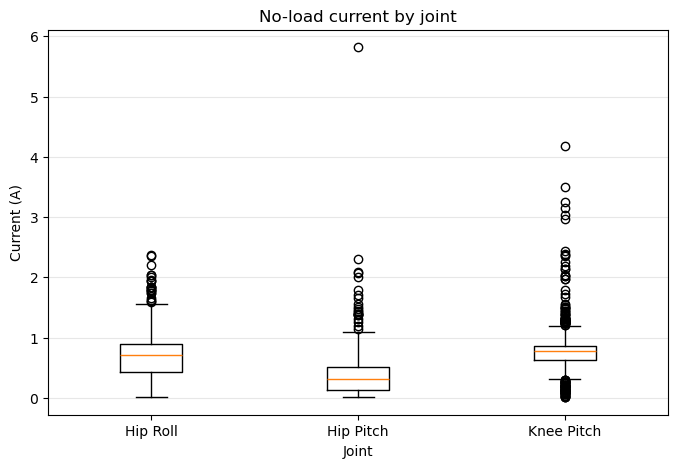

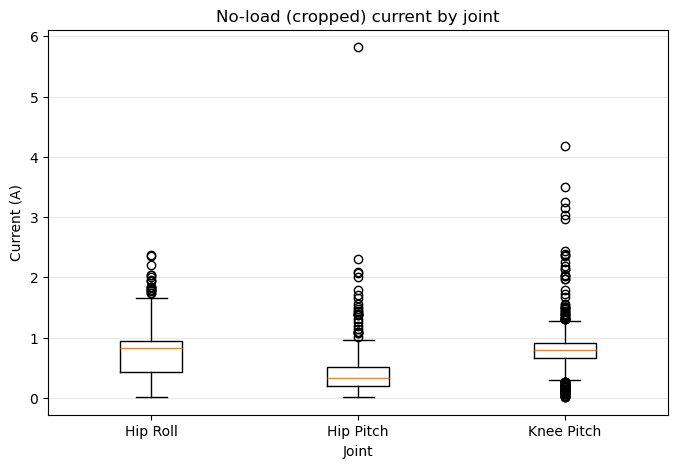

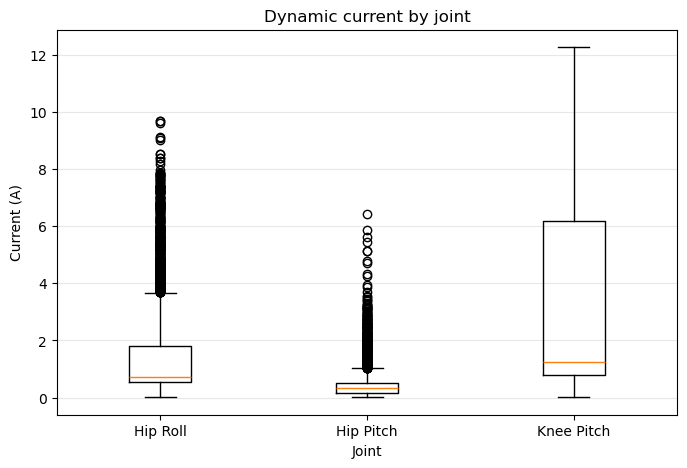

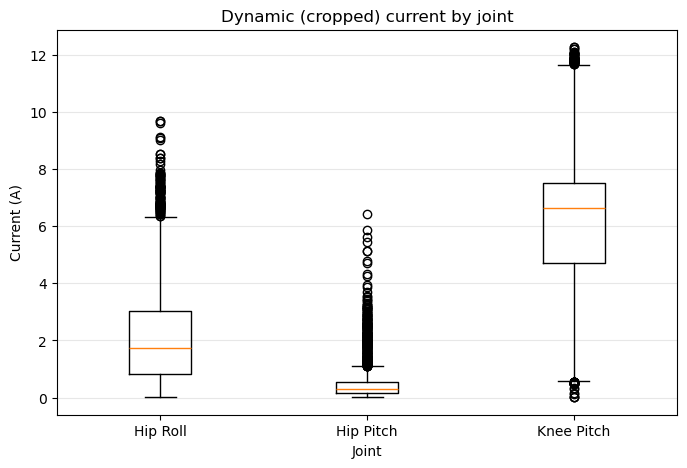

In [138]:
import matplotlib.pyplot as plt

_joint_label_map = {
    '0': 'Hip Roll',
    '1': 'Hip Pitch',
    '2': 'Knee Pitch',
}

def boxplots_per_joint(df, title):
    effort_cols = [c for c in df.columns if str(c).startswith('/joint_states.effort[')]
    if not effort_cols:
        raise ValueError('No effort columns found.')
    data = [df[c].dropna().values for c in effort_cols]
    labels = [c.split('[')[-1].split(']')[0] for c in effort_cols]
    labels = [_joint_label_map.get(l, l) for l in labels]

    plt.figure(figsize=(8, 5))
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.title(title)
    plt.xlabel('Joint')
    plt.ylabel('Current (A)')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

boxplots_per_joint(combined_no_load_c, 'No-load current by joint')
boxplots_per_joint(combined_no_load_cropped_c, 'No-load (cropped) current by joint')
boxplots_per_joint(combined_dynamic_c, 'Dynamic current by joint')
boxplots_per_joint(combined_dynamic_cropped_c, 'Dynamic (cropped) current by joint')

In [43]:
# 5-number summaries (min, Q1, median, Q3, max) for effort columns
def five_number_summary(df, cols=None):
    if cols is None:
        cols = [c for c in df.columns if str(c).startswith('/joint_states.effort[')]
    summary = df[cols].describe(percentiles=[0.25, 0.5, 0.75]).loc[
        ['min', '25%', '50%', '75%', 'max']
    ]
    return summary

no_load_summary = five_number_summary(combined_no_load_c)
dynamic_summary = five_number_summary(combined_dynamic_c)

print('No-load 5-number summary:')
display(no_load_summary)
print('Dynamic 5-number summary:')
display(dynamic_summary)


No-load 5-number summary:


,/joint_states.effort[0],/joint_states.effort[1],/joint_states.effort[2]
min,0.011570,0.011570,0.011570
25%,0.427994,0.127240,0.636206
50%,0.705609,0.312318,0.775016
75%,0.890687,0.520530,0.867553
max,2.371311,5.818392,4.175824


Dynamic 5-number summary:


,/joint_states.effort[0],/joint_states.effort[1],/joint_states.effort[2]
min,0.011570,0.011570,0.011570
25%,0.543665,0.173508,0.798150
50%,0.728743,0.335452,1.237709
75%,1.792943,0.520530,6.188548
max,9.705032,6.419897,12.272990


In [44]:
# Averages (means) for effort columns
effort_cols = [c for c in combined_no_load_c.columns if str(c).startswith('/joint_states.effort[')]

no_load_means = combined_no_load_c[effort_cols].mean()
dynamic_means = combined_dynamic_c[effort_cols].mean()

print('No-load means:')
display(no_load_means)
print('Dynamic means:')
display(dynamic_means)


No-load means:


/joint_states.effort[0]    0.668523
/joint_states.effort[1]    0.348404
/joint_states.effort[2]    0.752412
dtype: float64

Dynamic means:


/joint_states.effort[0]    1.314382
/joint_states.effort[1]    0.426406
/joint_states.effort[2]    3.521332
dtype: float64